## Data Preprocessing

In [1]:
# import necessary packages
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from IPython import display
import tensorflow as tf
import pandas as pd
import librosa

from sklearn.model_selection import train_test_split
from collections import Counter

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate, Dropout, BatchNormalization


# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
audio_path = 'dataset/AUDIO_NEW/'

audio_types = ['breathing', 'cough', 'speech']

In [4]:
def get_directories(audio_path, audio_type):
    from pathlib import Path

    POS = os.path.join(audio_path + audio_type, 'COVID_Positive')
    NEG = os.path.join(audio_path + audio_type, 'COVID_Negative')

    # Specify the directory path
    pos_directory = Path(POS)
    neg_directory = Path(NEG)
    
    return pos_directory, neg_directory

In [5]:
# Load and process breathing data
pos_directory_breathing, neg_directory_breathing = get_directories(audio_path, audio_types[0])

# Load and process cough data
pos_directory_cough, neg_directory_cough = get_directories(audio_path, audio_types[1]) # audio_types[1] is 'cough'

# Load and process speech data
pos_directory_speech, neg_directory_speech = get_directories(audio_path, audio_types[2]) # audio_types[2] is 'speech'


In [6]:
def create_mel_spectrogram(y, sr, file_path):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Normalize the spectrogram
    if np.std(log_mel_spectrogram) == 0:
        print("log_mel_spectrogram == 0: ", file_path.resolve())
    
    # Normalize the spectrogram
    epsilon = 1e-6  # Small value to avoid division by zero
    log_mel_spectrogram = (log_mel_spectrogram - np.mean(log_mel_spectrogram)) / (np.std(log_mel_spectrogram) + epsilon)

    # Add channel dimension
    log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)

    return log_mel_spectrogram

def create_zero_crossing_rate(y):
    return np.mean(librosa.feature.zero_crossing_rate(y))

def create_spectral_centroid(y, sr):
    return np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

In [7]:
import random 

def augment_audio_random(y, sr, target_length):
    """
    Applies a random augmentation (time stretching, pitch shifting, or adding noise) to an audio signal.

    Args:
        y (numpy.ndarray): The raw audio signal.
        sr (int): Sampling rate of the audio signal.
        target_length (int): Target length for padding/truncating the audio.

    Returns:
        numpy.ndarray: Augmented audio signal padded/truncated to the target length.
    """
    # Randomly choose an augmentation type
    augmentation_type = random.choice(["time_stretch", "pitch_shift", "add_noise"])

    if augmentation_type == "time_stretch":
        # Apply time stretching with a random rate between 0.8 and 1.2
        rate = random.uniform(0.8, 1.2)
        y_augmented = librosa.effects.time_stretch(y, rate=rate)

    elif augmentation_type == "pitch_shift":
        # Apply pitch shifting with a random number of semitones between -5 and +5
        n_steps = random.randint(-5, 5)
        y_augmented = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

    elif augmentation_type == "add_noise":
        # Add random Gaussian noise with a standard deviation of up to 0.01
        noise = np.random.normal(0, random.uniform(0.001, 0.01), y.shape)
        y_augmented = y + noise

    # Ensure the augmented audio is padded/truncated to the target length
    zero_padding = np.zeros(max(0, target_length - len(y_augmented)), dtype=np.float32)
    y_augmented_padded = np.concatenate([y_augmented[:target_length], zero_padding], axis=0)

    return y_augmented_padded

In [8]:
def augment_audio(y, sr, target_length):
    augmented_audios = []

    # Time Stretching
    augmented_audios.append(librosa.effects.time_stretch(y, rate=0.8))  # Slow down
    augmented_audios.append(librosa.effects.time_stretch(y, rate=1.2))  # Speed up

    # Pitch Shifting (use keyword arguments)
    augmented_audios.append(librosa.effects.pitch_shift(y=y, sr=sr, n_steps=2))  # Pitch up
    augmented_audios.append(librosa.effects.pitch_shift(y=y, sr=sr, n_steps=-2))  # Pitch down

    # Adding Noise
    noise = np.random.normal(0, 0.005, y.shape)
    augmented_audios.append(y + noise)

    # Ensure all augmented audios are padded/truncated to target_length
    padded_augmented_audios = []
    for aug_y in augmented_audios:
        zero_padding = np.zeros(max(0, target_length - len(aug_y)), dtype=np.float32)
        aug_y_padded = np.concatenate([aug_y[:target_length], zero_padding], axis=0)
        padded_augmented_audios.append(aug_y_padded)

    return padded_augmented_audios

In [9]:
def create_features(pos_directory, neg_directory, target_length, augment=False):
    print("Creating features for {0} and {1}! ".format(pos_directory, neg_directory))
    spectrograms = []
    other_features = []
    labels = []

    # Access files directly using iterdir()
    for file_path in sorted(pos_directory.iterdir()):
        y, sr = librosa.load(file_path, sr=16000)
        y = y[:target_length]
        y = librosa.util.normalize(y)

        zero_padding = np.zeros(target_length - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding], axis=0)

        spectrograms.append(create_mel_spectrogram(y, sr, file_path))
        other_features.append([create_zero_crossing_rate(y), create_spectral_centroid(y, sr)])
        labels.append(1)


        ## Augment random
        # if augment:
        #     y_augmented = augment_audio(y, sr, target_length)
        #     spectrograms.append(create_mel_spectrogram(y_augmented, sr, file_path))
        #     other_features.append([create_zero_crossing_rate(y_augmented), create_spectral_centroid(y_augmented, sr)])
        #     labels.append(1)

        ## Augment all
        if augment:
            augmented_audios = augment_audio(y, sr, target_length)
            for aug_y in augmented_audios:
                spectrograms.append(create_mel_spectrogram(aug_y, sr, file_path))
                other_features.append([create_zero_crossing_rate(aug_y), create_spectral_centroid(aug_y, sr)])
                labels.append(1)
    
    positive_samples = len(labels)

    print(f"Number of positive samples: {positive_samples}")  

    for file_path in sorted(neg_directory.iterdir()):
        y, sr = librosa.load(file_path, sr=16000)
        y = y[:target_length]

        zero_padding = np.zeros(target_length - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding], axis=0)

        spectrograms.append(create_mel_spectrogram(y, sr, file_path))
        other_features.append([create_zero_crossing_rate(y), create_spectral_centroid(y, sr)])
        labels.append(0)

        # if augment:
        #     y_augmented = augment_audio(y, sr, target_length)
        #     spectrograms.append(create_mel_spectrogram(y_augmented, sr, file_path))
        #     other_features.append([create_zero_crossing_rate(y_augmented), create_spectral_centroid(y_augmented, sr)])
        #     labels.append(0)

    print(f"Number of negative samples: {len(labels) - positive_samples}")           
    print("Completed creating features for {0} and {1}! ".format(pos_directory, neg_directory))

    return spectrograms, other_features, labels

In [10]:
# creating spectrogram, other features, and labels for breathing, cough, and speech

spectrograms_breathing, other_features_breathing, labels_breathing = create_features(pos_directory_breathing, neg_directory_breathing, 80000)

Creating features for dataset/AUDIO_NEW/breathing/COVID_Positive and dataset/AUDIO_NEW/breathing/COVID_Negative! 
Number of positive samples: 172
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/GDOLSUHV.flac
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/HTUZHMVC.flac
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/TMWZXJNT.flac
Number of negative samples: 793
Completed creating features for dataset/AUDIO_NEW/breathing/COVID_Positive and dataset/AUDIO_NEW/breathing/COVID_Negative! 


In [11]:
spectrograms_cough, other_features_cough, labels_cough = create_features(pos_directory_cough, neg_directory_cough, 96000) # 6 seconds 

# 25th Percentile Duration: 4.693333333333333
# Median Duration: 6.058684807256236
# 75th Percentile Duration: 7.509319727891157

Creating features for dataset/AUDIO_NEW/cough/COVID_Positive and dataset/AUDIO_NEW/cough/COVID_Negative! 
Number of positive samples: 172
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/cough/COVID_Negative/TMWZXJNT.flac
Number of negative samples: 793
Completed creating features for dataset/AUDIO_NEW/cough/COVID_Positive and dataset/AUDIO_NEW/cough/COVID_Negative! 


In [12]:
spectrograms_speech, other_features_speech, labels_speech = create_features(pos_directory_speech, neg_directory_speech, 160000) # 10 seconds

# 25th Percentile Duration: 12.458684807256235
# Median Duration: 14.421337868480725
# 75th Percentile Duration: 16.55467120181406

Creating features for dataset/AUDIO_NEW/speech/COVID_Positive and dataset/AUDIO_NEW/speech/COVID_Negative! 
Number of positive samples: 172
Number of negative samples: 793
Completed creating features for dataset/AUDIO_NEW/speech/COVID_Positive and dataset/AUDIO_NEW/speech/COVID_Negative! 


In [13]:
# Define a function to pad spectrograms to the maximum time frame length
def pad_spectrogram(spectrogram, max_time_frames):
    current_time_frames = spectrogram.shape[1]  # Time frames are along axis 1
    if current_time_frames < max_time_frames:
        # Calculate padding amount
        padding_amount = max_time_frames - current_time_frames
        # Pad along the time axis (axis=1)
        padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, padding_amount), (0, 0)), mode='constant')
    else:
        padded_spectrogram = spectrogram
    return padded_spectrogram

In [14]:
# Maximum time frame length across all audio types
max_time_frames = 1251

# Pad all spectrograms to the maximum time frame length
padded_spectrograms_breathing = [pad_spectrogram(s, max_time_frames) for s in spectrograms_breathing]
padded_spectrograms_cough = [pad_spectrogram(s, max_time_frames) for s in spectrograms_cough]
padded_spectrograms_speech = [pad_spectrogram(s, max_time_frames) for s in spectrograms_speech]

In [15]:
del spectrograms_breathing, spectrograms_cough, spectrograms_speech

In [17]:
# Combine spectrograms, other features, and labels for each participant
all_spectrograms = []
all_other_features = []
all_labels = []

# Assuming all lists are sorted in the same order and correspond to the same participants
for i in range(len(padded_spectrograms_breathing)):  # Iterate over participants

    combined_spectrogram = np.concatenate(
        [padded_spectrograms_breathing[i], padded_spectrograms_cough[i], padded_spectrograms_speech[i]], axis=1
    )
    
    # Combine other features for breathing, coughing, and speech
    combined_other_features = np.concatenate(
        [other_features_breathing[i], other_features_cough[i], other_features_speech[i]], axis=0
    )
    
    # Assume labels are consistent across all audio types for a participant
    label = labels_breathing[i]  # You can use any of the label lists since they are consistent

    # Append combined data to the final lists
    all_spectrograms.append(combined_spectrogram)
    all_other_features.append(combined_other_features)
    all_labels.append(label)

# Convert to NumPy arrays
all_spectrograms = np.array(all_spectrograms)
all_other_features = np.array(all_other_features)
all_labels = np.array(all_labels)

# Flatten spectrograms and combine with other features
all_spectrograms_flattened = all_spectrograms.reshape(all_spectrograms.shape[0], -1)
X_combined = np.hstack([all_spectrograms_flattened, all_other_features])


In [18]:
del all_spectrograms_flattened, all_spectrograms, all_other_features, padded_spectrograms_breathing, padded_spectrograms_cough, padded_spectrograms_speech

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, all_labels, test_size=0.2, stratify=all_labels)

In [22]:
del X_combined

In [32]:
import joblib

# Save the splits to a file
# joblib.dump((X_train, X_test, y_train, y_test), 'train_test_splits.pkl')

# To load the splits later
X_train, X_test, y_train, y_test = joblib.load('train_test_splits.pkl')

## SMOTEENN

- training balanced accuracy: `0.6131474932390264`
- testing balanced accuracy: `0.4841842397336293`

We used the `SMOTEENN` function in the imblearn library to handle imbalanced datasets by oversampling `1`, the minority class and remove noisy samples. 

In [33]:
print(f"Original class distribution: {Counter(y_train)}")

Original class distribution: Counter({np.int64(0): 634, np.int64(1): 138})


In [34]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from collections import Counter


# smote = SMOTE(sampling_strategy=0.5)  # Oversample minority class to 50% of majority class
enn = EditedNearestNeighbours(n_neighbors=3, kind_sel="mode") 
# smote_enn = SMOTEENN(smote=smote, enn=enn, random_state=seed)

smote_enn = SMOTEENN(random_state=seed,  sampling_strategy=0.65, enn=enn)
#smote_enn = SMOTEENN(random_state=seed,  sampling_strategy='minority', enn=enn)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

In [35]:
## sampling strategy = 0.6

print(f"Resampled class distribution: {Counter(y_train_resampled)}")

Resampled class distribution: Counter({np.int64(1): 412, np.int64(0): 232})


In [36]:
## sampling strategy = 0.7
print(f"Resampled class distribution: {Counter(y_train_resampled)}")
# 0s are mostly wrongly classified as 1s

Resampled class distribution: Counter({np.int64(1): 412, np.int64(0): 232})


In [37]:
del X_train, y_train

In [38]:
# Constants for updated time frames
num_mel_bands = 128
original_time_frames_breathing = 626 # prev: 622
original_time_frames_coughing = 751 # prev: 747
original_time_frames_speech = 1251 # prev: 1247
max_time_frames = 1251  # Maximum time frames across all audio types

# Total original time frames
original_total_time_frames = original_time_frames_breathing + original_time_frames_coughing + original_time_frames_speech

# Total spectrogram features
total_padded_spectrogram_features = num_mel_bands * (max_time_frames * 3)

In [39]:
# Separate resampled padded spectrograms and other features for X_train_resampled
padded_spectrograms_resampled = X_train_resampled[:, :total_padded_spectrogram_features]
other_features_resampled = X_train_resampled[:, total_padded_spectrogram_features:]

In [40]:
padded_spectrograms_resampled_reshaped = padded_spectrograms_resampled.reshape(
    padded_spectrograms_resampled.shape[0], num_mel_bands,
    max_time_frames * 3, 1
)


In [41]:
# Define a function to extract the original spectrograms without padding
def extract_original_spectrograms(padded_spectrograms, time_frames_breathing, time_frames_coughing, time_frames_speech):
    # Extract breathing spectrogram
    breathing = padded_spectrograms[:, :, :time_frames_breathing, :]
    
    # Extract coughing spectrogram
    coughing_start = time_frames_breathing
    coughing_end = time_frames_breathing + time_frames_coughing
    coughing = padded_spectrograms[:, :, coughing_start:coughing_end, :]
    
    # Extract speech spectrogram
    speech_start = coughing_end
    speech_end = speech_start + time_frames_speech
    speech = padded_spectrograms[:, :, speech_start:speech_end, :]
    
    return breathing, coughing, speech

# Extract the original spectrograms from the padded data
spectrograms_train_breathing, spectrograms_train_coughing, spectrograms_train_speech = extract_original_spectrograms(
    padded_spectrograms_resampled_reshaped,
    original_time_frames_breathing,
    original_time_frames_coughing,
    original_time_frames_speech
)

In [42]:
# Verify the shapes of the extracted spectrograms
print("Breathing Spectrogram Shape:", spectrograms_train_breathing.shape)  # Expected: (num_samples, 128, 622, 1)
print("Coughing Spectrogram Shape:", spectrograms_train_coughing.shape)   # Expected: (num_samples, 128, 747, 1)
print("Speech Spectrogram Shape:", spectrograms_train_speech.shape)       # Expected: (num_samples, 128, 1247, 1)

Breathing Spectrogram Shape: (644, 128, 626, 1)
Coughing Spectrogram Shape: (644, 128, 751, 1)
Speech Spectrogram Shape: (644, 128, 1251, 1)


### Process X_test

In [43]:
# For X_test (no resampling needed), separate and reshape the spectrograms
spectrograms_test = X_test[:, :total_padded_spectrogram_features]
other_features_test = X_test[:, total_padded_spectrogram_features:]

In [44]:
spectrograms_test_reshaped = spectrograms_test.reshape(
    spectrograms_test.shape[0], num_mel_bands, max_time_frames * 3, 1
)

In [45]:
# Separate spectrogram_test_reshaped into breathing, coughing, and speech
# spectrograms_test_breathing_resampled = spectrograms_test_reshaped[:, :, :num_time_frames, :]
# spectrograms_test_coughing_resampled = spectrograms_test_reshaped[:, :, num_time_frames:num_time_frames*2, :]
# spectrograms_test_speech_resampled = spectrograms_test_reshaped[:, :, num_time_frames*2:, :]

spectrograms_test_breathing, spectrograms_test_coughing, spectrograms_test_speech = extract_original_spectrograms(
    spectrograms_test_reshaped,
    original_time_frames_breathing,
    original_time_frames_coughing,
    original_time_frames_speech
)
# Verify shapes
print("Breathing Spectrogram Shape:", spectrograms_test_breathing.shape)
print("Coughing Spectrogram Shape:", spectrograms_test_coughing.shape)
print("Speech Spectrogram Shape:", spectrograms_test_speech.shape)


Breathing Spectrogram Shape: (193, 128, 626, 1)
Coughing Spectrogram Shape: (193, 128, 751, 1)
Speech Spectrogram Shape: (193, 128, 1251, 1)


In [46]:
#convert y_train_resampled and y_test to numpy arrays

y_train_resampled = np.array(y_train_resampled)
y_test = np.array(y_test)

### Full Model

In [47]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout, Add, LeakyReLU

def create_cnn_subnetwork_simplified(input_layer):
    # First Block
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer='l2')(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Second Block
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer='l2')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Residual Connection (Shortcut Path)
    shortcut = Conv2D(64, (1, 1), padding='same', kernel_regularizer='l2')(input_layer)  # Match dimensions
    shortcut = MaxPooling2D(pool_size=(4, 4))(shortcut) 
    shortcut = BatchNormalization()(shortcut)

    # Add Residual Connection
    x = Add()([x, shortcut])

    # Global Pooling
    x = GlobalAveragePooling2D()(x)

    return x

In [48]:
# Define input for Mel spectrogram (shape: 625 time frames x 128 frequency bins x 1 channel)
mel_input_breathing = Input(shape=(128, 626, 1), name='mel_spectrogram_breathing')
mel_input_cough = Input(shape=(128, 751, 1), name='mel_spectrogram_cough')
mel_input_speech = Input(shape=(128, 1251, 1), name='mel_spectrogram_speech')


# Define CNN sub-network for Mel spectrogram
# def create_cnn_subnetwork(input_layer):
#     x = Conv2D(16, (3,3), activation='relu')(input_layer)
#     x = MaxPooling2D(pool_size=(2,2))(x)
#     x = Conv2D(16, (3,3), activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2,2))(x)
#     x = Conv2D(32, (3,3), activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2,2))(x)
#     x = Conv2D(64, (3,3), activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2,2))(x)
#     x = GlobalAveragePooling2D()(x)

#     return x

def create_cnn_subnetwork(input_layer):
    # First Convolutional Block
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)  # Add Batch Normalization
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)  # Add Dropout after pooling
    
    # Second Convolutional Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)  # Add Batch Normalization
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)  # Add Dropout after pooling
    
    # Third Convolutional Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)  # Add Batch Normalization
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)  # Increase Dropout for deeper layers
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    return x

# Create CNN sub-networks for each spectrogram input
cnn_breathing_output = create_cnn_subnetwork(mel_input_breathing)
cnn_cough_output = create_cnn_subnetwork(mel_input_cough)
cnn_speech_output = create_cnn_subnetwork(mel_input_speech)

# cnn_breathing_output = create_cnn_subnetwork_simplified(mel_input_breathing)
# cnn_cough_output = create_cnn_subnetwork_simplified(mel_input_cough)
# cnn_speech_output = create_cnn_subnetwork_simplified(mel_input_speech)

# Define input for other features (zero-crossing rate and spectral centroid)
other_input = Input(shape=(6,), name='other_features')

# Define a simple dense sub-network for other features
y = Dense(64, activation='relu')(other_input)
y = Dense(128, activation='relu')(y)  # Add more dense layers
y = Dropout(0.3)(y)                   # Add dropout to prevent overfitting
y = Dense(128, activation='relu')(y)   # Another dense layer
y = Dense(64, activation='relu')(y)    # Another dense layer

# Concatenate both sub-networks
combined = Concatenate()([cnn_breathing_output, cnn_cough_output, cnn_speech_output, y])

# Add final classification layers
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)                    # Add dropout to prevent overfitting
z = Dense(64, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)  # Binary classification

In [49]:
# Define the model with two inputs
model = tf.keras.Model(inputs=[mel_input_breathing, mel_input_cough, mel_input_speech, other_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','recall','precision'])

In [50]:
X_train_breathing, X_val_breathing, \
X_train_coughing, X_val_coughing, \
X_train_speech, X_val_speech, \
X_train_other_features, X_val_other_features, \
y_train, y_val = train_test_split(
    spectrograms_train_breathing,
    spectrograms_train_coughing,
    spectrograms_train_speech,
    other_features_resampled,
    y_train_resampled,
    test_size=0.2,
    random_state=seed,
    stratify=y_train_resampled
)

# Step 2: Verify shapes of training and validation sets
print("Training set shapes:")
print("Breathing:", X_train_breathing.shape)
print("Coughing:", X_train_coughing.shape)
print("Speech:", X_train_speech.shape)
print("Other Features:", X_train_other_features.shape)
print("Labels:", y_train.shape)

print("\nValidation set shapes:")
print("Breathing:", X_val_breathing.shape)
print("Coughing:", X_val_coughing.shape)
print("Speech:", X_val_speech.shape)
print("Other Features:", X_val_other_features.shape)
print("Labels:", y_val.shape)


Training set shapes:
Breathing: (515, 128, 626, 1)
Coughing: (515, 128, 751, 1)
Speech: (515, 128, 1251, 1)
Other Features: (515, 6)
Labels: (515,)

Validation set shapes:
Breathing: (129, 128, 626, 1)
Coughing: (129, 128, 751, 1)
Speech: (129, 128, 1251, 1)
Other Features: (129, 6)
Labels: (129,)


In [51]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor (e.g., validation loss)
    patience=5,                 # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the weights of the best epoch
    verbose=1                   # Print messages when early stopping is triggered
)

history = model.fit(
    [X_train_breathing, X_train_coughing, X_train_speech, X_train_other_features],
    y_train,
    validation_data=(
        [X_val_breathing, X_val_coughing, X_val_speech, X_val_other_features],
        y_val
    ),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)


# Step 4: Evaluate the model on the validation set
results = model.evaluate(
    [X_val_breathing, X_val_coughing, X_val_speech, X_val_other_features],
    y_val
)

Epoch 1/20


/Users/opheliasin/covid-detection/venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['mel_spectrogram_breathing', 'mel_spectrogram_cough', 'mel_spectrogram_speech', 'other_features']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.5410 - loss: 17.3549 - precision: 0.6404 - recall: 0.6421 - val_accuracy: 0.6357 - val_loss: 1.2026 - val_precision: 0.6698 - val_recall: 0.8554
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.5738 - loss: 4.8197 - precision: 0.6795 - recall: 0.6494 - val_accuracy: 0.6667 - val_loss: 0.9672 - val_precision: 0.6613 - val_recall: 0.9880
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.5642 - loss: 3.7999 - precision: 0.6771 - recall: 0.6275 - val_accuracy: 0.6899 - val_loss: 0.7843 - val_precision: 0.6972 - val_recall: 0.9157
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.5503 - loss: 2.1923 - precision: 0.6637 - recall: 0.6213 - val_accuracy: 0.5969 - val_loss: 0.7729 - val_precision: 0.7460 - val_recall: 0.5663
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.5796 - loss: 1.5427 - precision: 0.6840 - recall: 0.6562 - val_accuracy: 0.6977 - val_loss: 0.5990 - val_precision

In [52]:
y_pred_train = model.predict([X_train_breathing, X_train_coughing, X_train_speech, X_train_other_features])

17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 585ms/step


In [ ]:
y_pred_train_binary = (y_pred_train > 0.6).astype(int)


from sklearn.metrics import accuracy_score, balanced_accuracy_score

balanced_acc = balanced_accuracy_score(y_train, y_pred_train_binary)
print(f"Balanced Accuracy: {balanced_acc * 100:.2f}%")

accuracy_train = accuracy_score(y_train, y_pred_train_binary)

print(f"Training Accuracy: {accuracy_train * 100:.2f}%")

Training Accuracy: 0.6932038834951456


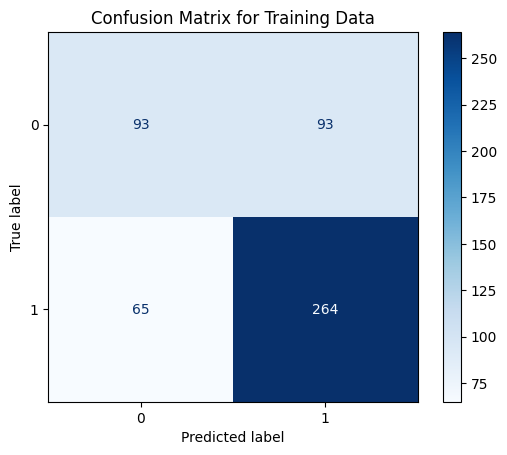

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train, y_pred_train_binary)

# Step 4: Visualize or print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Training Data")
plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score

# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(y_train, y_pred_train_binary)
print(f"Balanced Accuracy: {balanced_acc * 100:.2f}%")

Balanced Accuracy: 0.6512158054711246


In [56]:
y_pred_test = model.predict([spectrograms_test_breathing, spectrograms_test_coughing, spectrograms_test_speech, other_features_test])

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 602ms/step


In [57]:
y_pred_test_binary = (y_pred_test > 0.6).astype(int)

In [58]:
cm = confusion_matrix(y_test, y_pred_test_binary)

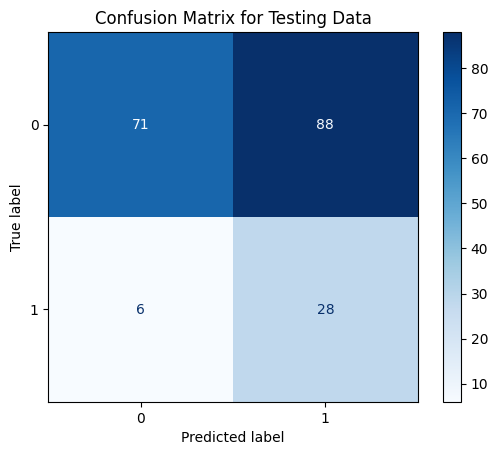

In [61]:
disp = ConfusionMatrixDisplay(cm)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Testing Data")
plt.show()

In [60]:
balanced_acc = balanced_accuracy_score(y_test, y_pred_test_binary)
print(f"Balanced Accuracy: {balanced_acc}")

Balanced Accuracy: 0.6350351461339252
